In [1]:
!pip install sentence-transformers
!pip install pandas


Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [2]:


from sklearn.metrics import accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression
from sentence_transformers import SentenceTransformer, InputExample, losses, models, datasets, evaluation
from torch.utils.data import DataLoader

from sklearn.manifold import TSNE
from matplotlib import pyplot as plt

# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np

import torch
import random
import torch
import random

def set_seed(seed):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)

In [3]:
#Load the sprag dataset
data = pd.read_csv("refstdcombined.csv")
data.head(2)

,Unnamed: 0,QuestionID,ReferenceAnswer,StudentAnswer,Score1,Score2,avg_score,max_score
0,0.0,PythonQ001,"List, Set and Dictionary are mutable data stru...",Tha object structures which can be changeable ...,1.0,0.0,0.5,1.0
1,1.0,PythonQ001,"List, Set and Dictionary are mutable data stru...",Tuple,0.0,0.0,0.0,0.0


In [4]:
data['bin_score'] = data.apply(lambda row : 1 if row.avg_score>=3 else 0, axis=1)

In [5]:
data.head(2)

,Unnamed: 0,QuestionID,ReferenceAnswer,StudentAnswer,Score1,Score2,avg_score,max_score,bin_score
0,0.0,PythonQ001,"List, Set and Dictionary are mutable data stru...",Tha object structures which can be changeable ...,1.0,0.0,0.5,1.0,0
1,1.0,PythonQ001,"List, Set and Dictionary are mutable data stru...",Tuple,0.0,0.0,0.0,0.0,0


In [6]:
data = data.dropna()

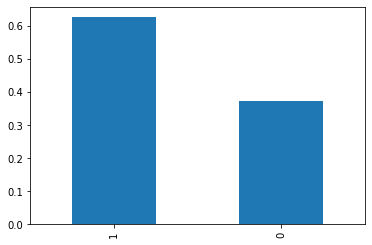

In [7]:
data['bin_score'].value_counts(normalize=True).plot(kind='bar');

In [8]:
#### Just some code to print debug information to stdout
import logging
from sentence_transformers import LoggingHandler
logging.basicConfig(format='%(asctime)s - %(message)s',
                    datefmt='%Y-%m-%d %H:%M:%S',
                    level=logging.INFO,
                    handlers=[LoggingHandler()])

In [9]:
from sklearn.model_selection import train_test_split

# Storing labels in array
labels = data['bin_score'].values

# Dropping labels column from data
data = data.drop(['bin_score'], axis=1)

# Splitting data into train and test sets in a 70/30 ratio
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, stratify=labels, random_state=42, test_size=0.2)

In [10]:
len(train_data)*0.75, type(train_labels), train_labels.shape


(2406.0, numpy.ndarray, (3208,))

In [11]:
train_data = train_data.iloc[0:2406]
train_labels = train_labels[0:2406]

In [12]:
type(train_data), type(train_labels), len(train_data), len(train_labels)

(pandas.core.frame.DataFrame, numpy.ndarray, 2406, 2406)

In [13]:

def random_deletion(sentence, p=0.2): 
  words = sentence.split()
  if len(words) <= 3:
    return ' '.join(words)
  remaining = list(filter(lambda x: random.uniform(0,1) > p,words)) 
  if len(remaining) == 0: # if not left, sample a random word
    return ' '.join([random.choice(words)])
  else:
    return ' '.join(remaining)


In [18]:
random_deletion("Hi i am ")

'Hi i am'

In [22]:
def sentence_pairs_generation(sentence1, sentence2, labels, pairs, datatype='train'):
	# initialize two empty lists to hold the (sentence, sentence) pairs and
	# labels to indicate if the grade of the pair

  numClassesList = np.unique(labels)
  #print(numClassesList)
  idx = [np.where(labels == i)[0] for i in numClassesList]
  #print(idx)
  i=0

  for idxA in range(len(sentence1)):      
    dAns = sentence1[idxA]
    sAns = sentence2[idxA]
    label = int(labels[idxA])
    
		  # prepare a pair and update the sentences and labels lists, respectively
    pairs.append(InputExample(texts=[dAns, sAns], label=label))
    
    if datatype=='train' and random.random() >= 0.5:
      sAns = random_deletion(sentence2[idxA])
      #print(sAns)
      pairs.append(InputExample(texts=[dAns, sAns], label=label))
      i = i+1
  
  print("No.of augmented examples : ", i)

     
	# return a 2-tuple of our image pairs and labels
  return (pairs)

In [23]:
set_seed(0)
# Equal samples per class training
#train_df_sample = pd.concat([train_df[train_df[1]==0].sample(num_training), train_df[train_df[1]==1].sample(num_training)])
x_train_dA = train_data['ReferenceAnswer'].values.tolist()
x_train_sA = train_data['StudentAnswer'].values.tolist()
y_train = train_labels.tolist()
y_train = [int(x) for x in y_train]

In [24]:
#use test dataset as dev dataset
x_test_dA = test_data['ReferenceAnswer'].values.tolist()
x_test_sA = test_data['StudentAnswer'].values.tolist()
y_test = test_labels / 1.0
y_test = test_labels.tolist()
#y_test = [int(x) for x in y_test]

test_examples = [] 
test_examples = sentence_pairs_generation(np.array(x_test_dA), np.array(x_test_sA), np.array(y_test), test_examples, datatype='test')

No.of augmented examples :  0


In [25]:
len(test_examples)

802

In [26]:
train_examples = [] 
train_examples = sentence_pairs_generation(np.array(x_train_dA), np.array(x_train_sA), np.array(y_train), train_examples)

No.of augmented examples :  1247


In [27]:
len(train_examples)

3653

In [28]:
# Save path of the model
from datetime import datetime
model_save_path = 'output/training_sprag_v4_'+datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

In [29]:
from sentence_transformers import evaluation
import math


def train_and_evaluate(st_model, train_dataloader, test_dataloader, num_epochs,model_save_path):
  model = SentenceTransformer(st_model)
  #for evaluation
  train_loss = losses.SoftmaxLoss(model=model, sentence_embedding_dimension=model.get_sentence_embedding_dimension(), num_labels=2)
  #test_evaluator = evaluation.EmbeddingSimilarityEvaluator.from_input_examples(test_examples, batch_size=16, name='SPRAG-test')
  x_test_dA = test_data['ReferenceAnswer'].values.tolist()
  x_test_sA = test_data['StudentAnswer'].values.tolist()
  y_test = test_labels 

  evaluator = evaluation.BinaryClassificationEvaluator(x_test_dA, x_test_sA, y_test)

  #configuring the training
  warmup_steps = math.ceil(len(train_dataloader) * num_epochs * 0.1) #10% of train data for warm-up
  print(warmup_steps)
  #train_loss = losses.CosineSimilarityLoss(model)
  model.fit(train_objectives=[(train_dataloader, train_loss)],
          evaluator=evaluator,
          epochs=num_epochs,
          warmup_steps=warmup_steps,
          show_progress_bar=True,  
          #evaluation_steps=50, 
          output_path=model_save_path,)
  print("Training done...")

In [30]:
st_model = 'stsb-distilbert-base'
num_epochs = 10
batch_size=16
model_save_path = "binary_sim_output/"+st_model
train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=batch_size)
  
test_dataloader = DataLoader(test_examples, shuffle=True, batch_size=batch_size)
model = train_and_evaluate(st_model, train_dataloader, test_dataloader, num_epochs, model_save_path)
print("\n\n")
print(" "*20, "*"*10, st_model , "*"*10)

# Load the stored model and evaluate its performance on mohler test dataset
model = SentenceTransformer(model_save_path)
train_loss = losses.SoftmaxLoss(model=model, sentence_embedding_dimension=model.get_sentence_embedding_dimension(), num_labels=2)
test_evaluator = evaluation.EmbeddingSimilarityEvaluator.from_input_examples(test_examples, batch_size=16, name='SPRAG-test')
test_evaluator(model, output_path=model_save_path)
train_loss.cuda()

x_test_dA = test_data['ReferenceAnswer'].values.tolist()
x_test_sA = test_data['StudentAnswer'].values.tolist()
y_test = test_labels 

evaluator = evaluation.BinaryClassificationEvaluator(x_test_dA, x_test_sA, y_test)
evaluator(model, output_path=model_save_path)


2022-09-07 18:54:37 - Load pretrained SentenceTransformer: stsb-distilbert-base
2022-09-07 18:54:38 - Use pytorch device: cuda
2022-09-07 18:54:38 - Softmax loss: #Vectors concatenated: 3
229


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Iteration:   0%|          | 0/229 [00:00<?, ?it/s]

2022-09-07 18:54:59 - Binary Accuracy Evaluation of the model on  dataset after epoch 0:
2022-09-07 18:54:59 - Accuracy with Cosine-Similarity:           78.80	(Threshold: 0.4616)
2022-09-07 18:54:59 - F1 with Cosine-Similarity:                 84.41	(Threshold: 0.3568)
2022-09-07 18:54:59 - Precision with Cosine-Similarity:          75.79
2022-09-07 18:54:59 - Recall with Cosine-Similarity:             95.23
2022-09-07 18:54:59 - Average Precision with Cosine-Similarity:  90.93

2022-09-07 18:54:59 - Accuracy with Manhattan-Distance:           79.55	(Threshold: 368.9156)
2022-09-07 18:54:59 - F1 with Manhattan-Distance:                 84.95	(Threshold: 369.6714)
2022-09-07 18:54:59 - Precision with Manhattan-Distance:          78.88
2022-09-07 18:54:59 - Recall with Manhattan-Distance:             92.05
2022-09-07 18:54:59 - Average Precision with Manhattan-Distance:  91.05

2022-09-07 18:54:59 - Accuracy with Euclidean-Distance:           79.18	(Threshold: 16.9174)
2022-09-07 18:54:

Iteration:   0%|          | 0/229 [00:00<?, ?it/s]

2022-09-07 18:55:18 - Binary Accuracy Evaluation of the model on  dataset after epoch 1:
2022-09-07 18:55:19 - Accuracy with Cosine-Similarity:           81.92	(Threshold: 0.3924)
2022-09-07 18:55:19 - F1 with Cosine-Similarity:                 86.38	(Threshold: 0.3924)
2022-09-07 18:55:19 - Precision with Cosine-Similarity:          81.85
2022-09-07 18:55:19 - Recall with Cosine-Similarity:             91.45
2022-09-07 18:55:19 - Average Precision with Cosine-Similarity:  91.84

2022-09-07 18:55:19 - Accuracy with Manhattan-Distance:           82.29	(Threshold: 386.6787)
2022-09-07 18:55:19 - F1 with Manhattan-Distance:                 86.65	(Threshold: 391.2766)
2022-09-07 18:55:19 - Precision with Manhattan-Distance:          81.69
2022-09-07 18:55:19 - Recall with Manhattan-Distance:             92.25
2022-09-07 18:55:19 - Average Precision with Manhattan-Distance:  91.92

2022-09-07 18:55:19 - Accuracy with Euclidean-Distance:           82.54	(Threshold: 17.6451)
2022-09-07 18:55:

Iteration:   0%|          | 0/229 [00:00<?, ?it/s]

2022-09-07 18:55:38 - Binary Accuracy Evaluation of the model on  dataset after epoch 2:
2022-09-07 18:55:39 - Accuracy with Cosine-Similarity:           81.17	(Threshold: 0.2022)
2022-09-07 18:55:39 - F1 with Cosine-Similarity:                 86.26	(Threshold: 0.1848)
2022-09-07 18:55:39 - Precision with Cosine-Similarity:          79.53
2022-09-07 18:55:39 - Recall with Cosine-Similarity:             94.23
2022-09-07 18:55:39 - Average Precision with Cosine-Similarity:  91.22

2022-09-07 18:55:39 - Accuracy with Manhattan-Distance:           81.67	(Threshold: 445.3369)
2022-09-07 18:55:39 - F1 with Manhattan-Distance:                 86.62	(Threshold: 452.7309)
2022-09-07 18:55:39 - Precision with Manhattan-Distance:          79.44
2022-09-07 18:55:39 - Recall with Manhattan-Distance:             95.23
2022-09-07 18:55:39 - Average Precision with Manhattan-Distance:  91.46

2022-09-07 18:55:39 - Accuracy with Euclidean-Distance:           81.67	(Threshold: 20.5046)
2022-09-07 18:55:

Iteration:   0%|          | 0/229 [00:00<?, ?it/s]

2022-09-07 18:55:57 - Binary Accuracy Evaluation of the model on  dataset after epoch 3:
2022-09-07 18:55:58 - Accuracy with Cosine-Similarity:           80.55	(Threshold: 0.4012)
2022-09-07 18:55:58 - F1 with Cosine-Similarity:                 85.77	(Threshold: 0.1245)
2022-09-07 18:55:58 - Precision with Cosine-Similarity:          78.42
2022-09-07 18:55:58 - Recall with Cosine-Similarity:             94.63
2022-09-07 18:55:58 - Average Precision with Cosine-Similarity:  91.15

2022-09-07 18:55:58 - Accuracy with Manhattan-Distance:           81.05	(Threshold: 395.6289)
2022-09-07 18:55:58 - F1 with Manhattan-Distance:                 85.77	(Threshold: 478.9796)
2022-09-07 18:55:58 - Precision with Manhattan-Distance:          78.42
2022-09-07 18:55:58 - Recall with Manhattan-Distance:             94.63
2022-09-07 18:55:58 - Average Precision with Manhattan-Distance:  91.33

2022-09-07 18:55:58 - Accuracy with Euclidean-Distance:           81.05	(Threshold: 17.9122)
2022-09-07 18:55:

Iteration:   0%|          | 0/229 [00:00<?, ?it/s]

2022-09-07 18:56:17 - Binary Accuracy Evaluation of the model on  dataset after epoch 4:
2022-09-07 18:56:17 - Accuracy with Cosine-Similarity:           81.05	(Threshold: 0.4431)
2022-09-07 18:56:17 - F1 with Cosine-Similarity:                 85.58	(Threshold: 0.1929)
2022-09-07 18:56:17 - Precision with Cosine-Similarity:          79.52
2022-09-07 18:56:17 - Recall with Cosine-Similarity:             92.64
2022-09-07 18:56:17 - Average Precision with Cosine-Similarity:  91.07

2022-09-07 18:56:17 - Accuracy with Manhattan-Distance:           80.67	(Threshold: 377.9612)
2022-09-07 18:56:17 - F1 with Manhattan-Distance:                 85.64	(Threshold: 469.1945)
2022-09-07 18:56:17 - Precision with Manhattan-Distance:          78.89
2022-09-07 18:56:17 - Recall with Manhattan-Distance:             93.64
2022-09-07 18:56:17 - Average Precision with Manhattan-Distance:  91.18

2022-09-07 18:56:17 - Accuracy with Euclidean-Distance:           80.92	(Threshold: 18.6107)
2022-09-07 18:56:

Iteration:   0%|          | 0/229 [00:00<?, ?it/s]

2022-09-07 18:56:36 - Binary Accuracy Evaluation of the model on  dataset after epoch 5:
2022-09-07 18:56:37 - Accuracy with Cosine-Similarity:           81.30	(Threshold: 0.1743)
2022-09-07 18:56:37 - F1 with Cosine-Similarity:                 85.96	(Threshold: 0.1743)
2022-09-07 18:56:37 - Precision with Cosine-Similarity:          81.24
2022-09-07 18:56:37 - Recall with Cosine-Similarity:             91.25
2022-09-07 18:56:37 - Average Precision with Cosine-Similarity:  90.97

2022-09-07 18:56:37 - Accuracy with Manhattan-Distance:           81.05	(Threshold: 465.0609)
2022-09-07 18:56:37 - F1 with Manhattan-Distance:                 85.77	(Threshold: 465.0609)
2022-09-07 18:56:37 - Precision with Manhattan-Distance:          81.06
2022-09-07 18:56:37 - Recall with Manhattan-Distance:             91.05
2022-09-07 18:56:37 - Average Precision with Manhattan-Distance:  91.14

2022-09-07 18:56:37 - Accuracy with Euclidean-Distance:           81.05	(Threshold: 20.7593)
2022-09-07 18:56:

Iteration:   0%|          | 0/229 [00:00<?, ?it/s]

2022-09-07 18:56:55 - Binary Accuracy Evaluation of the model on  dataset after epoch 6:
2022-09-07 18:56:56 - Accuracy with Cosine-Similarity:           81.30	(Threshold: 0.1804)
2022-09-07 18:56:56 - F1 with Cosine-Similarity:                 85.93	(Threshold: 0.1804)
2022-09-07 18:56:56 - Precision with Cosine-Similarity:          81.35
2022-09-07 18:56:56 - Recall with Cosine-Similarity:             91.05
2022-09-07 18:56:56 - Average Precision with Cosine-Similarity:  90.86

2022-09-07 18:56:56 - Accuracy with Manhattan-Distance:           81.17	(Threshold: 472.0653)
2022-09-07 18:56:56 - F1 with Manhattan-Distance:                 85.93	(Threshold: 472.0653)
2022-09-07 18:56:56 - Precision with Manhattan-Distance:          80.88
2022-09-07 18:56:56 - Recall with Manhattan-Distance:             91.65
2022-09-07 18:56:56 - Average Precision with Manhattan-Distance:  90.96

2022-09-07 18:56:56 - Accuracy with Euclidean-Distance:           81.30	(Threshold: 21.5557)
2022-09-07 18:56:

Iteration:   0%|          | 0/229 [00:00<?, ?it/s]

2022-09-07 18:57:14 - Binary Accuracy Evaluation of the model on  dataset after epoch 7:
2022-09-07 18:57:14 - Accuracy with Cosine-Similarity:           81.55	(Threshold: 0.4114)
2022-09-07 18:57:14 - F1 with Cosine-Similarity:                 85.63	(Threshold: 0.4114)
2022-09-07 18:57:14 - Precision with Cosine-Similarity:          83.68
2022-09-07 18:57:14 - Recall with Cosine-Similarity:             87.67
2022-09-07 18:57:14 - Average Precision with Cosine-Similarity:  90.89

2022-09-07 18:57:14 - Accuracy with Manhattan-Distance:           81.42	(Threshold: 365.1011)
2022-09-07 18:57:14 - F1 with Manhattan-Distance:                 85.63	(Threshold: 434.0256)
2022-09-07 18:57:14 - Precision with Manhattan-Distance:          81.62
2022-09-07 18:57:14 - Recall with Manhattan-Distance:             90.06
2022-09-07 18:57:14 - Average Precision with Manhattan-Distance:  91.00

2022-09-07 18:57:14 - Accuracy with Euclidean-Distance:           81.55	(Threshold: 16.8506)
2022-09-07 18:57:

Iteration:   0%|          | 0/229 [00:00<?, ?it/s]

2022-09-07 18:57:32 - Binary Accuracy Evaluation of the model on  dataset after epoch 8:
2022-09-07 18:57:33 - Accuracy with Cosine-Similarity:           81.30	(Threshold: 0.2571)
2022-09-07 18:57:33 - F1 with Cosine-Similarity:                 85.85	(Threshold: 0.2233)
2022-09-07 18:57:33 - Precision with Cosine-Similarity:          81.69
2022-09-07 18:57:33 - Recall with Cosine-Similarity:             90.46
2022-09-07 18:57:33 - Average Precision with Cosine-Similarity:  91.05

2022-09-07 18:57:33 - Accuracy with Manhattan-Distance:           81.67	(Threshold: 402.5538)
2022-09-07 18:57:33 - F1 with Manhattan-Distance:                 85.82	(Threshold: 442.7583)
2022-09-07 18:57:33 - Precision with Manhattan-Distance:          81.80
2022-09-07 18:57:33 - Recall with Manhattan-Distance:             90.26
2022-09-07 18:57:33 - Average Precision with Manhattan-Distance:  91.15

2022-09-07 18:57:33 - Accuracy with Euclidean-Distance:           81.42	(Threshold: 18.6108)
2022-09-07 18:57:

Iteration:   0%|          | 0/229 [00:00<?, ?it/s]

2022-09-07 18:57:51 - Binary Accuracy Evaluation of the model on  dataset after epoch 9:
2022-09-07 18:57:51 - Accuracy with Cosine-Similarity:           81.67	(Threshold: 0.3789)
2022-09-07 18:57:51 - F1 with Cosine-Similarity:                 85.93	(Threshold: 0.3759)
2022-09-07 18:57:51 - Precision with Cosine-Similarity:          82.84
2022-09-07 18:57:51 - Recall with Cosine-Similarity:             89.26
2022-09-07 18:57:51 - Average Precision with Cosine-Similarity:  91.05

2022-09-07 18:57:51 - Accuracy with Manhattan-Distance:           81.80	(Threshold: 405.7445)
2022-09-07 18:57:51 - F1 with Manhattan-Distance:                 85.99	(Threshold: 405.7445)
2022-09-07 18:57:51 - Precision with Manhattan-Distance:          83.12
2022-09-07 18:57:51 - Recall with Manhattan-Distance:             89.07
2022-09-07 18:57:51 - Average Precision with Manhattan-Distance:  91.11

2022-09-07 18:57:51 - Accuracy with Euclidean-Distance:           81.67	(Threshold: 18.5909)
2022-09-07 18:57:

0.9198119808974333

In [31]:
st_model = 'sentence-transformers/paraphrase-albert-small-v2'
num_epochs = 10
batch_size=16
model_save_path = "binary_sim_output/"+st_model
train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=batch_size)
  
test_dataloader = DataLoader(test_examples, shuffle=True, batch_size=batch_size)
model = train_and_evaluate(st_model, train_dataloader, test_dataloader, num_epochs, model_save_path)
print("\n\n")
print(" "*20, "*"*10, st_model , "*"*10)

# Load the stored model and evaluate its performance on mohler test dataset
model = SentenceTransformer(model_save_path)
train_loss = losses.SoftmaxLoss(model=model, sentence_embedding_dimension=model.get_sentence_embedding_dimension(), num_labels=2)
test_evaluator = evaluation.EmbeddingSimilarityEvaluator.from_input_examples(test_examples, batch_size=16, name='SPRAG-test')
test_evaluator(model, output_path=model_save_path)
train_loss.cuda()

x_test_dA = test_data['ReferenceAnswer'].values.tolist()
x_test_sA = test_data['StudentAnswer'].values.tolist()
y_test = test_labels 

evaluator = evaluation.BinaryClassificationEvaluator(x_test_dA, x_test_sA, y_test)
evaluator(model, output_path=model_save_path)


2022-09-07 18:57:54 - Load pretrained SentenceTransformer: sentence-transformers/paraphrase-albert-small-v2
2022-09-07 18:57:54 - Use pytorch device: cuda
2022-09-07 18:57:54 - Softmax loss: #Vectors concatenated: 3
229


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Iteration:   0%|          | 0/229 [00:00<?, ?it/s]

2022-09-07 18:58:11 - Binary Accuracy Evaluation of the model on  dataset after epoch 0:
2022-09-07 18:58:11 - Accuracy with Cosine-Similarity:           79.18	(Threshold: 0.5186)
2022-09-07 18:58:11 - F1 with Cosine-Similarity:                 83.32	(Threshold: 0.5169)
2022-09-07 18:58:11 - Precision with Cosine-Similarity:          83.73
2022-09-07 18:58:11 - Recall with Cosine-Similarity:             82.90
2022-09-07 18:58:11 - Average Precision with Cosine-Similarity:  88.52

2022-09-07 18:58:11 - Accuracy with Manhattan-Distance:           77.68	(Threshold: 536.3831)
2022-09-07 18:58:11 - F1 with Manhattan-Distance:                 83.46	(Threshold: 553.2213)
2022-09-07 18:58:11 - Precision with Manhattan-Distance:          77.61
2022-09-07 18:58:11 - Recall with Manhattan-Distance:             90.26
2022-09-07 18:58:11 - Average Precision with Manhattan-Distance:  88.30

2022-09-07 18:58:11 - Accuracy with Euclidean-Distance:           77.81	(Threshold: 24.4337)
2022-09-07 18:58:

Iteration:   0%|          | 0/229 [00:00<?, ?it/s]

2022-09-07 18:58:28 - Binary Accuracy Evaluation of the model on  dataset after epoch 1:
2022-09-07 18:58:29 - Accuracy with Cosine-Similarity:           79.43	(Threshold: 0.4670)
2022-09-07 18:58:29 - F1 with Cosine-Similarity:                 83.96	(Threshold: 0.3712)
2022-09-07 18:58:29 - Precision with Cosine-Similarity:          76.77
2022-09-07 18:58:29 - Recall with Cosine-Similarity:             92.64
2022-09-07 18:58:29 - Average Precision with Cosine-Similarity:  88.64

2022-09-07 18:58:29 - Accuracy with Manhattan-Distance:           79.80	(Threshold: 617.5675)
2022-09-07 18:58:29 - F1 with Manhattan-Distance:                 84.74	(Threshold: 626.7361)
2022-09-07 18:58:29 - Precision with Manhattan-Distance:          79.24
2022-09-07 18:58:29 - Recall with Manhattan-Distance:             91.05
2022-09-07 18:58:29 - Average Precision with Manhattan-Distance:  88.53

2022-09-07 18:58:29 - Accuracy with Euclidean-Distance:           79.80	(Threshold: 27.9679)
2022-09-07 18:58:

Iteration:   0%|          | 0/229 [00:00<?, ?it/s]

2022-09-07 18:58:46 - Binary Accuracy Evaluation of the model on  dataset after epoch 2:
2022-09-07 18:58:46 - Accuracy with Cosine-Similarity:           81.17	(Threshold: 0.3892)
2022-09-07 18:58:46 - F1 with Cosine-Similarity:                 85.55	(Threshold: 0.3892)
2022-09-07 18:58:46 - Precision with Cosine-Similarity:          82.47
2022-09-07 18:58:46 - Recall with Cosine-Similarity:             88.87
2022-09-07 18:58:46 - Average Precision with Cosine-Similarity:  89.69

2022-09-07 18:58:46 - Accuracy with Manhattan-Distance:           79.93	(Threshold: 692.3163)
2022-09-07 18:58:46 - F1 with Manhattan-Distance:                 85.20	(Threshold: 742.7900)
2022-09-07 18:58:46 - Precision with Manhattan-Distance:          77.61
2022-09-07 18:58:46 - Recall with Manhattan-Distance:             94.43
2022-09-07 18:58:46 - Average Precision with Manhattan-Distance:  89.75

2022-09-07 18:58:46 - Accuracy with Euclidean-Distance:           80.42	(Threshold: 31.9835)
2022-09-07 18:58:

Iteration:   0%|          | 0/229 [00:00<?, ?it/s]

2022-09-07 18:59:03 - Binary Accuracy Evaluation of the model on  dataset after epoch 3:
2022-09-07 18:59:03 - Accuracy with Cosine-Similarity:           80.80	(Threshold: 0.3294)
2022-09-07 18:59:03 - F1 with Cosine-Similarity:                 85.71	(Threshold: 0.3294)
2022-09-07 18:59:03 - Precision with Cosine-Similarity:          80.35
2022-09-07 18:59:03 - Recall with Cosine-Similarity:             91.85
2022-09-07 18:59:03 - Average Precision with Cosine-Similarity:  89.58

2022-09-07 18:59:04 - Accuracy with Manhattan-Distance:           79.80	(Threshold: 717.0208)
2022-09-07 18:59:04 - F1 with Manhattan-Distance:                 84.96	(Threshold: 752.1400)
2022-09-07 18:59:04 - Precision with Manhattan-Distance:          78.45
2022-09-07 18:59:04 - Recall with Manhattan-Distance:             92.64
2022-09-07 18:59:04 - Average Precision with Manhattan-Distance:  89.75

2022-09-07 18:59:04 - Accuracy with Euclidean-Distance:           79.80	(Threshold: 32.1711)
2022-09-07 18:59:

Iteration:   0%|          | 0/229 [00:00<?, ?it/s]

2022-09-07 18:59:20 - Binary Accuracy Evaluation of the model on  dataset after epoch 4:
2022-09-07 18:59:21 - Accuracy with Cosine-Similarity:           79.80	(Threshold: 0.4516)
2022-09-07 18:59:21 - F1 with Cosine-Similarity:                 85.20	(Threshold: 0.2571)
2022-09-07 18:59:21 - Precision with Cosine-Similarity:          78.43
2022-09-07 18:59:21 - Recall with Cosine-Similarity:             93.24
2022-09-07 18:59:21 - Average Precision with Cosine-Similarity:  89.78

2022-09-07 18:59:21 - Accuracy with Manhattan-Distance:           79.55	(Threshold: 714.0787)
2022-09-07 18:59:21 - F1 with Manhattan-Distance:                 85.02	(Threshold: 806.6598)
2022-09-07 18:59:21 - Precision with Manhattan-Distance:          77.85
2022-09-07 18:59:21 - Recall with Manhattan-Distance:             93.64
2022-09-07 18:59:21 - Average Precision with Manhattan-Distance:  89.89

2022-09-07 18:59:21 - Accuracy with Euclidean-Distance:           79.18	(Threshold: 35.4562)
2022-09-07 18:59:

Iteration:   0%|          | 0/229 [00:00<?, ?it/s]

2022-09-07 18:59:38 - Binary Accuracy Evaluation of the model on  dataset after epoch 5:
2022-09-07 18:59:38 - Accuracy with Cosine-Similarity:           80.30	(Threshold: 0.3878)
2022-09-07 18:59:38 - F1 with Cosine-Similarity:                 85.07	(Threshold: 0.3481)
2022-09-07 18:59:38 - Precision with Cosine-Similarity:          80.60
2022-09-07 18:59:38 - Recall with Cosine-Similarity:             90.06
2022-09-07 18:59:38 - Average Precision with Cosine-Similarity:  89.87

2022-09-07 18:59:38 - Accuracy with Manhattan-Distance:           79.80	(Threshold: 761.8762)
2022-09-07 18:59:38 - F1 with Manhattan-Distance:                 84.92	(Threshold: 836.4608)
2022-09-07 18:59:38 - Precision with Manhattan-Distance:          77.02
2022-09-07 18:59:38 - Recall with Manhattan-Distance:             94.63
2022-09-07 18:59:38 - Average Precision with Manhattan-Distance:  89.86

2022-09-07 18:59:38 - Accuracy with Euclidean-Distance:           79.55	(Threshold: 34.4749)
2022-09-07 18:59:

Iteration:   0%|          | 0/229 [00:00<?, ?it/s]

2022-09-07 18:59:55 - Binary Accuracy Evaluation of the model on  dataset after epoch 6:
2022-09-07 18:59:56 - Accuracy with Cosine-Similarity:           80.05	(Threshold: 0.4676)
2022-09-07 18:59:56 - F1 with Cosine-Similarity:                 84.85	(Threshold: 0.2021)
2022-09-07 18:59:56 - Precision with Cosine-Similarity:          76.52
2022-09-07 18:59:56 - Recall with Cosine-Similarity:             95.23
2022-09-07 18:59:56 - Average Precision with Cosine-Similarity:  89.36

2022-09-07 18:59:56 - Accuracy with Manhattan-Distance:           79.55	(Threshold: 711.6614)
2022-09-07 18:59:56 - F1 with Manhattan-Distance:                 85.18	(Threshold: 839.1413)
2022-09-07 18:59:56 - Precision with Manhattan-Distance:          76.92
2022-09-07 18:59:56 - Recall with Manhattan-Distance:             95.43
2022-09-07 18:59:56 - Average Precision with Manhattan-Distance:  89.37

2022-09-07 18:59:56 - Accuracy with Euclidean-Distance:           79.30	(Threshold: 32.9896)
2022-09-07 18:59:

Iteration:   0%|          | 0/229 [00:00<?, ?it/s]

2022-09-07 19:00:12 - Binary Accuracy Evaluation of the model on  dataset after epoch 7:
2022-09-07 19:00:13 - Accuracy with Cosine-Similarity:           79.93	(Threshold: 0.3681)
2022-09-07 19:00:13 - F1 with Cosine-Similarity:                 84.98	(Threshold: 0.1319)
2022-09-07 19:00:13 - Precision with Cosine-Similarity:          76.47
2022-09-07 19:00:13 - Recall with Cosine-Similarity:             95.63
2022-09-07 19:00:13 - Average Precision with Cosine-Similarity:  89.53

2022-09-07 19:00:13 - Accuracy with Manhattan-Distance:           79.43	(Threshold: 750.9167)
2022-09-07 19:00:13 - F1 with Manhattan-Distance:                 84.75	(Threshold: 825.1589)
2022-09-07 19:00:13 - Precision with Manhattan-Distance:          77.96
2022-09-07 19:00:13 - Recall with Manhattan-Distance:             92.84
2022-09-07 19:00:13 - Average Precision with Manhattan-Distance:  89.46

2022-09-07 19:00:13 - Accuracy with Euclidean-Distance:           79.30	(Threshold: 36.5647)
2022-09-07 19:00:

Iteration:   0%|          | 0/229 [00:00<?, ?it/s]

2022-09-07 19:00:29 - Binary Accuracy Evaluation of the model on  dataset after epoch 8:
2022-09-07 19:00:30 - Accuracy with Cosine-Similarity:           79.68	(Threshold: 0.3938)
2022-09-07 19:00:30 - F1 with Cosine-Similarity:                 84.87	(Threshold: 0.1869)
2022-09-07 19:00:30 - Precision with Cosine-Similarity:          77.20
2022-09-07 19:00:30 - Recall with Cosine-Similarity:             94.23
2022-09-07 19:00:30 - Average Precision with Cosine-Similarity:  89.55

2022-09-07 19:00:30 - Accuracy with Manhattan-Distance:           79.55	(Threshold: 750.1478)
2022-09-07 19:00:30 - F1 with Manhattan-Distance:                 84.94	(Threshold: 833.5925)
2022-09-07 19:00:30 - Precision with Manhattan-Distance:          78.13
2022-09-07 19:00:30 - Recall with Manhattan-Distance:             93.04
2022-09-07 19:00:30 - Average Precision with Manhattan-Distance:  89.48

2022-09-07 19:00:30 - Accuracy with Euclidean-Distance:           79.43	(Threshold: 36.1748)
2022-09-07 19:00:

Iteration:   0%|          | 0/229 [00:00<?, ?it/s]

2022-09-07 19:00:47 - Binary Accuracy Evaluation of the model on  dataset after epoch 9:
2022-09-07 19:00:47 - Accuracy with Cosine-Similarity:           79.93	(Threshold: 0.4814)
2022-09-07 19:00:47 - F1 with Cosine-Similarity:                 84.94	(Threshold: 0.2371)
2022-09-07 19:00:47 - Precision with Cosine-Similarity:          77.72
2022-09-07 19:00:47 - Recall with Cosine-Similarity:             93.64
2022-09-07 19:00:47 - Average Precision with Cosine-Similarity:  89.57

2022-09-07 19:00:47 - Accuracy with Manhattan-Distance:           79.43	(Threshold: 699.8207)
2022-09-07 19:00:47 - F1 with Manhattan-Distance:                 84.93	(Threshold: 850.3741)
2022-09-07 19:00:47 - Precision with Manhattan-Distance:          76.64
2022-09-07 19:00:47 - Recall with Manhattan-Distance:             95.23
2022-09-07 19:00:47 - Average Precision with Manhattan-Distance:  89.58

2022-09-07 19:00:47 - Accuracy with Euclidean-Distance:           79.55	(Threshold: 35.3529)
2022-09-07 19:00:

0.8988632797809347

In [32]:

st_model = 'sentence-transformers/quora-distilbert-base'
num_epochs = 10
batch_size=16
model_save_path = "binary_sim_output/"+st_model
train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=batch_size)
  
test_dataloader = DataLoader(test_examples, shuffle=True, batch_size=batch_size)
model = train_and_evaluate(st_model, train_dataloader, test_dataloader, num_epochs, model_save_path)
print("\n\n")
print(" "*20, "*"*10, st_model , "*"*10)

# Load the stored model and evaluate its performance on mohler test dataset
model = SentenceTransformer(model_save_path)
train_loss = losses.SoftmaxLoss(model=model, sentence_embedding_dimension=model.get_sentence_embedding_dimension(), num_labels=2)
test_evaluator = evaluation.EmbeddingSimilarityEvaluator.from_input_examples(test_examples, batch_size=16, name='SPRAG-test')
test_evaluator(model, output_path=model_save_path)
train_loss.cuda()

x_test_dA = test_data['ReferenceAnswer'].values.tolist()
x_test_sA = test_data['StudentAnswer'].values.tolist()
y_test = test_labels 

evaluator = evaluation.BinaryClassificationEvaluator(x_test_dA, x_test_sA, y_test)
evaluator(model, output_path=model_save_path)


2022-09-07 19:00:50 - Load pretrained SentenceTransformer: sentence-transformers/quora-distilbert-base
2022-09-07 19:00:50 - Use pytorch device: cuda
2022-09-07 19:00:50 - Softmax loss: #Vectors concatenated: 3
229


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Iteration:   0%|          | 0/229 [00:00<?, ?it/s]

2022-09-07 19:01:08 - Binary Accuracy Evaluation of the model on  dataset after epoch 0:
2022-09-07 19:01:09 - Accuracy with Cosine-Similarity:           79.55	(Threshold: 0.4752)
2022-09-07 19:01:09 - F1 with Cosine-Similarity:                 84.89	(Threshold: 0.3929)
2022-09-07 19:01:09 - Precision with Cosine-Similarity:          77.50
2022-09-07 19:01:09 - Recall with Cosine-Similarity:             93.84
2022-09-07 19:01:09 - Average Precision with Cosine-Similarity:  90.48

2022-09-07 19:01:09 - Accuracy with Manhattan-Distance:           78.43	(Threshold: 326.9354)
2022-09-07 19:01:09 - F1 with Manhattan-Distance:                 84.20	(Threshold: 345.3604)
2022-09-07 19:01:09 - Precision with Manhattan-Distance:          75.71
2022-09-07 19:01:09 - Recall with Manhattan-Distance:             94.83
2022-09-07 19:01:09 - Average Precision with Manhattan-Distance:  89.59

2022-09-07 19:01:09 - Accuracy with Euclidean-Distance:           78.43	(Threshold: 14.7021)
2022-09-07 19:01:

Iteration:   0%|          | 0/229 [00:00<?, ?it/s]

2022-09-07 19:01:28 - Binary Accuracy Evaluation of the model on  dataset after epoch 1:
2022-09-07 19:01:28 - Accuracy with Cosine-Similarity:           81.92	(Threshold: 0.4480)
2022-09-07 19:01:28 - F1 with Cosine-Similarity:                 86.49	(Threshold: 0.4086)
2022-09-07 19:01:28 - Precision with Cosine-Similarity:          81.40
2022-09-07 19:01:28 - Recall with Cosine-Similarity:             92.25
2022-09-07 19:01:28 - Average Precision with Cosine-Similarity:  91.95

2022-09-07 19:01:28 - Accuracy with Manhattan-Distance:           80.55	(Threshold: 335.8401)
2022-09-07 19:01:28 - F1 with Manhattan-Distance:                 85.20	(Threshold: 335.8401)
2022-09-07 19:01:28 - Precision with Manhattan-Distance:          81.49
2022-09-07 19:01:28 - Recall with Manhattan-Distance:             89.26
2022-09-07 19:01:28 - Average Precision with Manhattan-Distance:  90.97

2022-09-07 19:01:28 - Accuracy with Euclidean-Distance:           80.92	(Threshold: 14.9948)
2022-09-07 19:01:

Iteration:   0%|          | 0/229 [00:00<?, ?it/s]

2022-09-07 19:01:47 - Binary Accuracy Evaluation of the model on  dataset after epoch 2:
2022-09-07 19:01:48 - Accuracy with Cosine-Similarity:           81.67	(Threshold: 0.5311)
2022-09-07 19:01:48 - F1 with Cosine-Similarity:                 85.93	(Threshold: 0.5100)
2022-09-07 19:01:48 - Precision with Cosine-Similarity:          82.84
2022-09-07 19:01:48 - Recall with Cosine-Similarity:             89.26
2022-09-07 19:01:48 - Average Precision with Cosine-Similarity:  91.74

2022-09-07 19:01:48 - Accuracy with Manhattan-Distance:           81.17	(Threshold: 350.2568)
2022-09-07 19:01:48 - F1 with Manhattan-Distance:                 85.77	(Threshold: 350.2568)
2022-09-07 19:01:48 - Precision with Manhattan-Distance:          81.54
2022-09-07 19:01:48 - Recall with Manhattan-Distance:             90.46
2022-09-07 19:01:48 - Average Precision with Manhattan-Distance:  91.53

2022-09-07 19:01:48 - Accuracy with Euclidean-Distance:           81.05	(Threshold: 15.2150)
2022-09-07 19:01:

Iteration:   0%|          | 0/229 [00:00<?, ?it/s]

2022-09-07 19:02:06 - Binary Accuracy Evaluation of the model on  dataset after epoch 3:
2022-09-07 19:02:06 - Accuracy with Cosine-Similarity:           81.17	(Threshold: 0.5157)
2022-09-07 19:02:06 - F1 with Cosine-Similarity:                 85.59	(Threshold: 0.1070)
2022-09-07 19:02:06 - Precision with Cosine-Similarity:          77.46
2022-09-07 19:02:06 - Recall with Cosine-Similarity:             95.63
2022-09-07 19:02:06 - Average Precision with Cosine-Similarity:  91.71

2022-09-07 19:02:06 - Accuracy with Manhattan-Distance:           80.55	(Threshold: 351.8164)
2022-09-07 19:02:06 - F1 with Manhattan-Distance:                 85.38	(Threshold: 425.3116)
2022-09-07 19:02:06 - Precision with Manhattan-Distance:          77.78
2022-09-07 19:02:06 - Recall with Manhattan-Distance:             94.63
2022-09-07 19:02:06 - Average Precision with Manhattan-Distance:  91.21

2022-09-07 19:02:06 - Accuracy with Euclidean-Distance:           80.30	(Threshold: 15.6058)
2022-09-07 19:02:

Iteration:   0%|          | 0/229 [00:00<?, ?it/s]

2022-09-07 19:02:25 - Binary Accuracy Evaluation of the model on  dataset after epoch 4:
2022-09-07 19:02:25 - Accuracy with Cosine-Similarity:           80.80	(Threshold: 0.5574)
2022-09-07 19:02:25 - F1 with Cosine-Similarity:                 85.32	(Threshold: 0.3400)
2022-09-07 19:02:25 - Precision with Cosine-Similarity:          79.66
2022-09-07 19:02:25 - Recall with Cosine-Similarity:             91.85
2022-09-07 19:02:25 - Average Precision with Cosine-Similarity:  91.71

2022-09-07 19:02:25 - Accuracy with Manhattan-Distance:           80.67	(Threshold: 347.0094)
2022-09-07 19:02:25 - F1 with Manhattan-Distance:                 85.48	(Threshold: 439.3744)
2022-09-07 19:02:25 - Precision with Manhattan-Distance:          78.22
2022-09-07 19:02:25 - Recall with Manhattan-Distance:             94.23
2022-09-07 19:02:25 - Average Precision with Manhattan-Distance:  91.53

2022-09-07 19:02:25 - Accuracy with Euclidean-Distance:           80.67	(Threshold: 15.3824)
2022-09-07 19:02:

Iteration:   0%|          | 0/229 [00:00<?, ?it/s]

2022-09-07 19:02:44 - Binary Accuracy Evaluation of the model on  dataset after epoch 5:
2022-09-07 19:02:44 - Accuracy with Cosine-Similarity:           79.93	(Threshold: 0.2327)
2022-09-07 19:02:44 - F1 with Cosine-Similarity:                 85.30	(Threshold: 0.2327)
2022-09-07 19:02:44 - Precision with Cosine-Similarity:          78.89
2022-09-07 19:02:44 - Recall with Cosine-Similarity:             92.84
2022-09-07 19:02:44 - Average Precision with Cosine-Similarity:  91.14

2022-09-07 19:02:44 - Accuracy with Manhattan-Distance:           79.93	(Threshold: 370.8111)
2022-09-07 19:02:44 - F1 with Manhattan-Distance:                 85.38	(Threshold: 451.3709)
2022-09-07 19:02:44 - Precision with Manhattan-Distance:          78.18
2022-09-07 19:02:44 - Recall with Manhattan-Distance:             94.04
2022-09-07 19:02:44 - Average Precision with Manhattan-Distance:  90.99

2022-09-07 19:02:44 - Accuracy with Euclidean-Distance:           79.93	(Threshold: 19.8491)
2022-09-07 19:02:

Iteration:   0%|          | 0/229 [00:00<?, ?it/s]

2022-09-07 19:03:03 - Binary Accuracy Evaluation of the model on  dataset after epoch 6:
2022-09-07 19:03:03 - Accuracy with Cosine-Similarity:           80.05	(Threshold: 0.4501)
2022-09-07 19:03:03 - F1 with Cosine-Similarity:                 85.20	(Threshold: 0.1116)
2022-09-07 19:03:03 - Precision with Cosine-Similarity:          78.43
2022-09-07 19:03:03 - Recall with Cosine-Similarity:             93.24
2022-09-07 19:03:03 - Average Precision with Cosine-Similarity:  91.09

2022-09-07 19:03:03 - Accuracy with Manhattan-Distance:           80.17	(Threshold: 395.8991)
2022-09-07 19:03:03 - F1 with Manhattan-Distance:                 84.96	(Threshold: 398.8896)
2022-09-07 19:03:03 - Precision with Manhattan-Distance:          81.05
2022-09-07 19:03:03 - Recall with Manhattan-Distance:             89.26
2022-09-07 19:03:03 - Average Precision with Manhattan-Distance:  90.91

2022-09-07 19:03:03 - Accuracy with Euclidean-Distance:           80.17	(Threshold: 17.7163)
2022-09-07 19:03:

Iteration:   0%|          | 0/229 [00:00<?, ?it/s]

2022-09-07 19:03:21 - Binary Accuracy Evaluation of the model on  dataset after epoch 7:
2022-09-07 19:03:22 - Accuracy with Cosine-Similarity:           80.42	(Threshold: 0.4413)
2022-09-07 19:03:22 - F1 with Cosine-Similarity:                 84.94	(Threshold: 0.0221)
2022-09-07 19:03:22 - Precision with Cosine-Similarity:          78.13
2022-09-07 19:03:22 - Recall with Cosine-Similarity:             93.04
2022-09-07 19:03:22 - Average Precision with Cosine-Similarity:  91.03

2022-09-07 19:03:22 - Accuracy with Manhattan-Distance:           80.42	(Threshold: 379.4109)
2022-09-07 19:03:22 - F1 with Manhattan-Distance:                 84.80	(Threshold: 379.4109)
2022-09-07 19:03:22 - Precision with Manhattan-Distance:          82.64
2022-09-07 19:03:22 - Recall with Manhattan-Distance:             87.08
2022-09-07 19:03:22 - Average Precision with Manhattan-Distance:  90.74

2022-09-07 19:03:22 - Accuracy with Euclidean-Distance:           80.42	(Threshold: 17.1493)
2022-09-07 19:03:

Iteration:   0%|          | 0/229 [00:00<?, ?it/s]

2022-09-07 19:03:40 - Binary Accuracy Evaluation of the model on  dataset after epoch 8:
2022-09-07 19:03:41 - Accuracy with Cosine-Similarity:           80.05	(Threshold: 0.3626)
2022-09-07 19:03:41 - F1 with Cosine-Similarity:                 85.15	(Threshold: -0.1328)
2022-09-07 19:03:41 - Precision with Cosine-Similarity:          77.40
2022-09-07 19:03:41 - Recall with Cosine-Similarity:             94.63
2022-09-07 19:03:41 - Average Precision with Cosine-Similarity:  91.05

2022-09-07 19:03:41 - Accuracy with Manhattan-Distance:           79.80	(Threshold: 369.6907)
2022-09-07 19:03:41 - F1 with Manhattan-Distance:                 84.76	(Threshold: 528.1753)
2022-09-07 19:03:41 - Precision with Manhattan-Distance:          76.11
2022-09-07 19:03:41 - Recall with Manhattan-Distance:             95.63
2022-09-07 19:03:41 - Average Precision with Manhattan-Distance:  90.78

2022-09-07 19:03:41 - Accuracy with Euclidean-Distance:           79.80	(Threshold: 16.9573)
2022-09-07 19:03

Iteration:   0%|          | 0/229 [00:00<?, ?it/s]

2022-09-07 19:03:59 - Binary Accuracy Evaluation of the model on  dataset after epoch 9:
2022-09-07 19:03:59 - Accuracy with Cosine-Similarity:           80.55	(Threshold: 0.4678)
2022-09-07 19:03:59 - F1 with Cosine-Similarity:                 85.13	(Threshold: -0.0809)
2022-09-07 19:03:59 - Precision with Cosine-Similarity:          77.49
2022-09-07 19:03:59 - Recall with Cosine-Similarity:             94.43
2022-09-07 19:03:59 - Average Precision with Cosine-Similarity:  91.07

2022-09-07 19:03:59 - Accuracy with Manhattan-Distance:           80.17	(Threshold: 370.6890)
2022-09-07 19:03:59 - F1 with Manhattan-Distance:                 84.93	(Threshold: 522.0721)
2022-09-07 19:03:59 - Precision with Manhattan-Distance:          76.64
2022-09-07 19:03:59 - Recall with Manhattan-Distance:             95.23
2022-09-07 19:03:59 - Average Precision with Manhattan-Distance:  90.88

2022-09-07 19:03:59 - Accuracy with Euclidean-Distance:           80.30	(Threshold: 17.0758)
2022-09-07 19:03

0.9194782594693177

In [33]:
#Our sentences we like to encode
s1 = model.encode("Python is an object oriented programming language")
s2 = model.encode("java is an oop language")

s1.shape

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

(768,)

In [34]:
#Compute cosine similarity between all pairs
from sentence_transformers import util
cos_sim = util.cos_sim(s1, s2)
cos_sim

tensor([[0.2374]])